In [1]:
import pandas as pd

Checking an example csv for heart rate


In [2]:
df_ex_hr=pd.read_csv('datasets/COVID-19-Wearables/A0KX894_hr.csv')
df_ex_hr.head(10)

,user,datetime,heartrate
0,A0KX894,2026-07-22 00:00:04,78
1,A0KX894,2026-07-22 00:00:09,77
2,A0KX894,2026-07-22 00:00:14,76
3,A0KX894,2026-07-22 00:00:19,75
4,A0KX894,2026-07-22 00:00:24,74
5,A0KX894,2026-07-22 00:00:29,75
6,A0KX894,2026-07-22 00:00:34,74
7,A0KX894,2026-07-22 00:00:49,74
8,A0KX894,2026-07-22 00:00:54,77
9,A0KX894,2026-07-22 00:00:59,76


In [3]:
df_ex_hr.describe()

,heartrate
count,879561.000000
mean,76.706986
std,14.771697
min,47.000000
25%,66.000000
50%,75.000000
75%,85.000000
max,181.000000


In [4]:
df_ex_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879561 entries, 0 to 879560
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       879561 non-null  object
 1   datetime   879561 non-null  object
 2   heartrate  879561 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.1+ MB


In [5]:
df_ex_hr['datetime'].describe()

count                  879561
unique                 879561
top       2026-07-22 00:00:04
freq                        1
Name: datetime, dtype: object

Max heart rate is normally 220 - 20, as the data recorded complies with the standards of Stanford universities, the participants should be around or superior to 20. lets do a quick check on one of the recorded data


In [6]:
nan_entries = df_ex_hr.isna().sum()
illogical_entries = df_ex_hr[(df_ex_hr['heartrate'] < 30)| (df_ex_hr['heartrate'] > 200)].sum()
print('Number of NaN entries: ', nan_entries)
print('Number of illogical entries: ', illogical_entries)

Number of NaN entries:  user         0
datetime     0
heartrate    0
dtype: int64
Number of illogical entries:  user         0.0
datetime     0.0
heartrate    0.0
dtype: float64


Lets ittereate over the directories and save a dictionary containing the users name and the corresponding hr and steps

In [11]:
import os
dir_csv = 'datasets/COVID-19-Wearables/'
files = [f for f in os.listdir(dir_csv) if f.endswith('.csv')] # we can straight do it with os.listdir
# noticed there are some files with user name containing_1 or _2, so we need to put that into consideration
#user_name = [f.split('_')[0] if f.count("_")==1 else ""for f in files]
# will deal with it inside the dictionary better
user_name = [f.split('_')[0] for f in files]
mult=0
for i in user_name:
    if(user_name.count(i)) < 1:
        print('missing data for user: ', i)
    if(user_name.count(i)) > 2:
        mult+=1
       
user_name_unique = list(set(user_name))

dict_user_data={}   
for i in user_name_unique:
    dict_user_data[i] = dict()# I am not concatinating strings, there is a user with multi entries
    dict_user_data[i]['hr'] = [f for f in files if f == i+'_hr.csv']
   
    
# to visualize all the directory structure


In [34]:
import neurokit2 as nk
merged_df_same_user_dict = {}
merged_df_processed = {}

for user in dict_user_data.keys():
    if dict_user_data[user]['hr'] != []:
        df_hr = pd.read_csv(dir_csv + dict_user_data[user]['hr'][0])
     
        df_hr['datetime'] = pd.to_datetime(df_hr['datetime'])
        df_hr.set_index('datetime', inplace=True)
        df_hr=df_hr.resample('20Min').mean() # resample to 20 min #interpolate nah we need just heart
        #df_hr['heartrate'].resample('1min').mean()
        df_hr['datetime'] = df_hr.index
    merged_df_same_user_dict[user]=df_hr
    #merged_df_same_user_dict_2[user]=pd.merge(df_hr, df_steps, left_index=True, right_index=True, how="outer")



In [35]:
merged_df_same_user_dict['A0KX894'].head()

,heartrate,datetime
datetime,,
2026-07-22 00:00:00,76.241573,2026-07-22 00:00:00
2026-07-22 00:20:00,80.453608,2026-07-22 00:20:00
2026-07-22 00:40:00,90.808989,2026-07-22 00:40:00
2026-07-22 01:00:00,89.578947,2026-07-22 01:00:00
2026-07-22 01:20:00,87.853933,2026-07-22 01:20:00


In [36]:
df_t = merged_df_same_user_dict['A0KX894']

/Users/rayendhahri/opt/anaconda3/envs/machine/lib/python3.8/site-packages/neurokit2/ecg/ecg_clean.py:91: NeuroKitWarning: There are 1105 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(


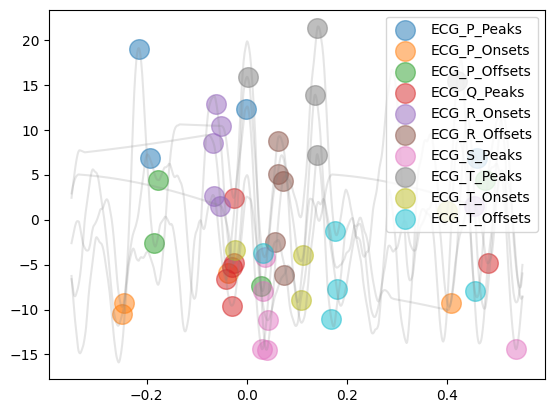

In [38]:
cleaned_ecg = nk.ecg_clean(df_t["heartrate"], sampling_rate=1000, method='neurokit')
r_signals, r_info = nk.ecg_peaks(cleaned_ecg, sampling_rate=1000)
peak_signals, peak_waves = nk.ecg_delineate(cleaned_ecg, r_info['ECG_R_Peaks'], sampling_rate=1000, method='dwt', show=True, show_type="all")

In [39]:
peak_waves

{'ECG_P_Peaks': [125, 2645, 3525, 5458, 5670],
 'ECG_P_Onsets': [nan, 2612, 3473, 5424, 5635],
 'ECG_P_Offsets': [154, 2674, 3541, 5487, 5700],
 'ECG_Q_Peaks': [599, 3037, 3689, 5631, 6153],
 'ECG_R_Onsets': [574, 3000, 3658, 5607, 6126],
 'ECG_R_Offsets': [697, 3141, 3780, 5734, 6234],
 'ECG_S_Peaks': [665, 3108, 3754, 5704, 6209],
 'ECG_T_Peaks': [766, 3720, 3855, 6318, 6598],
 'ECG_T_Onsets': [nan, 3694, 3831, 6286, 6578],
 'ECG_T_Offsets': [801, 3750, 3898, 6347, 6633]}

In [ ]:
df_t.head()

,heartrate,user,datetime
datetime,,,
2026-07-22 00:00:00,76.081633,A0KX894,2026-07-22 00:00:00
2026-07-22 00:05:00,75.928571,A0KX894,2026-07-22 00:05:00
2026-07-22 00:10:00,75.155556,A0KX894,2026-07-22 00:10:00
2026-07-22 00:15:00,77.904762,A0KX894,2026-07-22 00:15:00
2026-07-22 00:20:00,77.255814,A0KX894,2026-07-22 00:20:00


In [ ]:
len(df_t)

26784

In [ ]:
df_master = pd.concat(merged_df_same_user_dict.values(), ignore_index=True)

In [ ]:
df_master["user"].unique() # confirmed all users are in the master df

array(['A6BUI4N', 'AE2B3RH', 'AWRBUQZ', 'A6GEBIK', 'ATHKM6V', 'AF3J1YC',
       'ASFODQR', 'AMQUHOQ', 'AWA2KJK', 'AQ4TMLV', 'AV2GF3B', 'AOB9SON',
       'A3OU183', 'A5XL2IC', 'AXCO7I9', 'AAF9ACE', 'AFEFA29', 'AL48GP3',
       'AAXAA7Z', 'AFPB8J2', 'A4E0D03', 'A36HR6Y', 'APGIB2T', 'A3ADWUT',
       'AKXN5ZZ', 'A8QLAB0', 'AJ7TSV9', 'A0KX894', 'AW4EXXK', 'ATT9RR1',
       'A11SQQN', 'ALZDAVZ', 'AQ25Y0L', 'AOQA85X', 'AKV66US', 'AQC0L71',
       'AYEFCWQ', 'AJWW3IY', 'AO20DS4', 'AE0MQ94', 'A7EM0B6', 'AXDWDEA',
       'AZIK4ZA', 'AZKZ0AI', 'AX3KEW9', 'AJ0DKQ3', 'AFHOHOM', 'A4G0044',
       'AD77K91', 'AOGFRXL', 'AXD3W8O', 'AFYLHG4', 'A8CBEJZ', 'AK7YRBU',
       'AQR8ZSS', 'A91HEZV', 'AHP25OJ', 'A35BJNV', 'AF8R0I6', 'A7EAWA7',
       'AZ35PI5', 'AA2KP1S', 'AEOBCFJ', 'A4H7SNF', 'AUILKHG', 'ALKAXMZ',
       'A2XFW2N', 'ARR2IKE', 'AOS4BSJ', 'AXI1PBS', 'A0822M0', 'A1ZJ41O',
       'A17YCA2', 'AGYQJEL', 'AUY8KYW', 'A0N9NV4', 'AYWIEKR', 'AAGTWZK',
       'AY8TPMP', 'A06L7KF', 'A0VFT1N', 'ARYB2QO', 

In [ ]:
df_master.to_csv('datasets/df_master_hr_light_processed.csv')